In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [28]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

TRAIN_DIR = "/content/drive/MyDrive/new work/Dataset/train"
TEST_DIR  = "/content/drive/MyDrive/new work/Dataset/train"   # separate test folder

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [30]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)

In [31]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_it = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

test_it = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_it.class_indices.keys())
num_classes = len(class_names)

print("\nClass indices:", train_it.class_indices)
print("Class names:", class_names)

Found 7597 images belonging to 4 classes.
Found 7597 images belonging to 4 classes.

Class indices: {'Hyperpigmentation': 0, 'Nail fungus': 1, 'clubbing': 2, 'normal': 3}
Class names: ['Hyperpigmentation', 'Nail fungus', 'clubbing', 'normal']


In [32]:
batchX, batchy = next(train_it)
print(f"\nBatch shape={batchX.shape}, min={batchX.min():.3f}, max={batchX.max():.3f}")


Batch shape=(32, 224, 224, 3), min=-1.000, max=1.000


In [33]:
backbone = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

In [34]:
backbone.trainable = False

x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)
out = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=backbone.input, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("best_inceptionv3.keras", monitor="val_loss", save_best_only=True),
]

In [36]:
EPOCHS = 20
history = model.fit(
    train_it,
    validation_data=test_it,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 169s 657ms/step - accuracy: 0.6120 - loss: 0.9488 - val_accuracy: 0.8767 - val_loss: 0.3709 - learning_rate: 0.0010
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 595ms/step - accuracy: 0.8497 - loss: 0.4342 - val_accuracy: 0.9071 - val_loss: 0.2811 - learning_rate: 0.0010
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 591ms/step - accuracy: 0.8741 - loss: 0.3537 - val_accuracy: 0.9294 - val_loss: 0.2340 - learning_rate: 0.0010
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 590ms/step - accuracy: 0.8913 - loss: 0.3081 - val_accuracy: 0.9347 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 140s 587ms/step - accuracy: 0.9022 - loss: 0.2795 - val_accuracy: 0.9462 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 140s 586ms/step - accuracy: 0.9004 - loss: 0.2777 - val_accuracy: 0.9325 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 584ms/step - accura

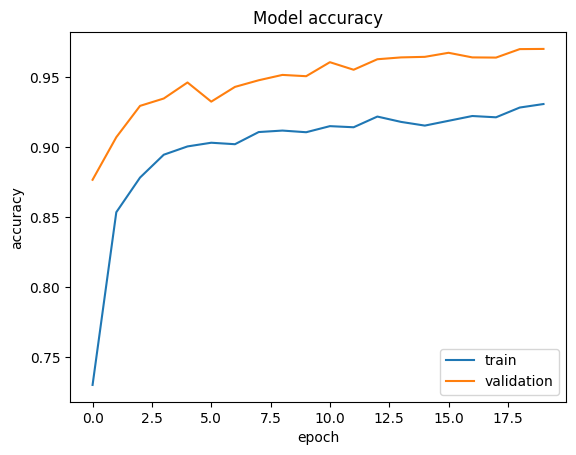

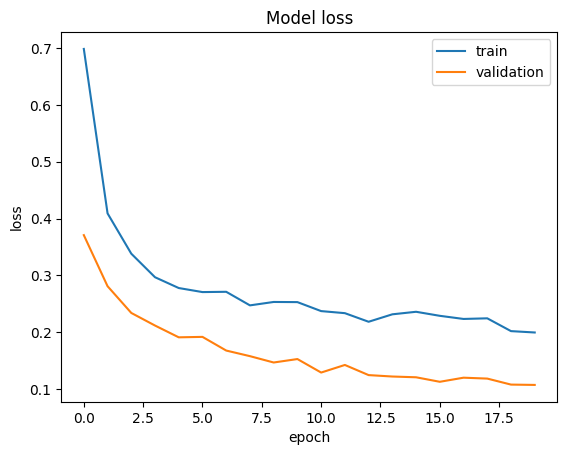

In [37]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="lower right")
plt.show()

plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()


238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step


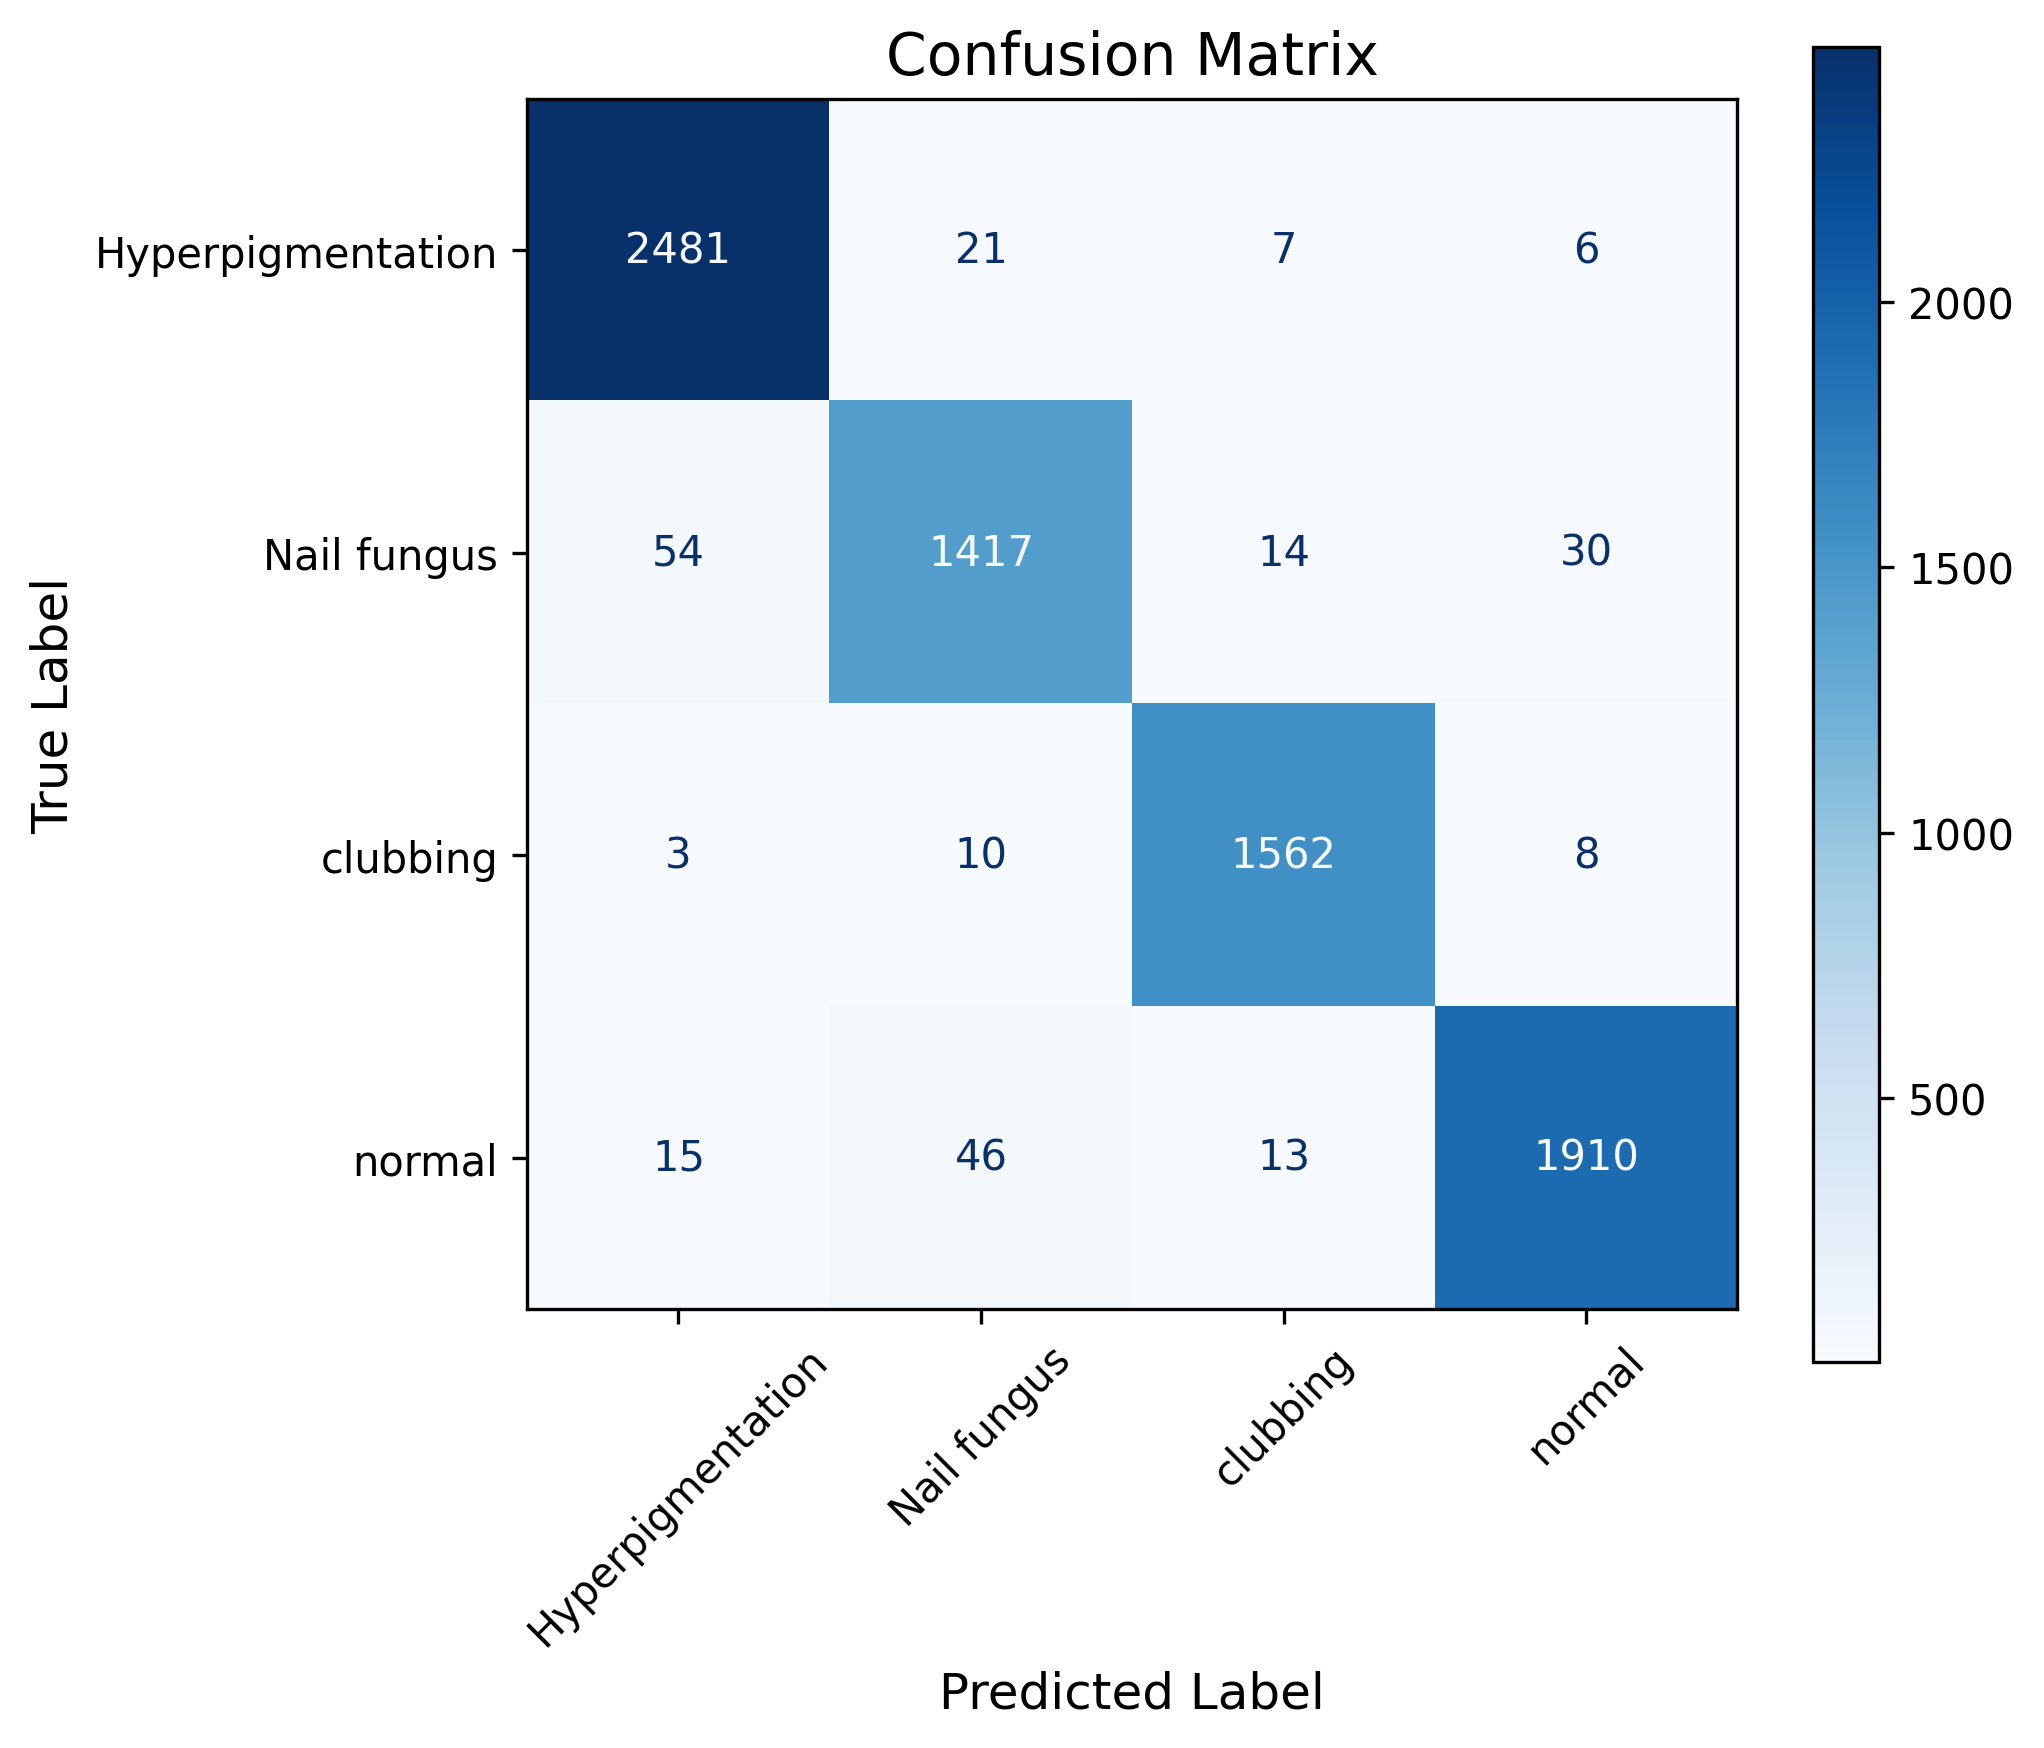


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation     0.9718    0.9865    0.9791      2515
      Nail fungus     0.9485    0.9353    0.9418      1515
         clubbing     0.9787    0.9867    0.9827      1583
           normal     0.9775    0.9627    0.9700      1984

         accuracy                         0.9701      7597
        macro avg     0.9691    0.9678    0.9684      7597
     weighted avg     0.9701    0.9701    0.9700      7597


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation       0.97      0.99      0.98      2515
      Nail fungus       0.95      0.94      0.94      1515
         clubbing       0.98      0.99      0.98      1583
           normal       0.98      0.96      0.97      1984

         accuracy                           0.97      7597
        macro avg       0.97      0.97      0.97      7597
     weighted avg       0.97      0.97      0.97      7597



In [42]:
# # Reset generator
test_it.reset()

# Predictions
Y_pred = model.predict(test_it, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_it.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# High-quality figure
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    ax=ax,
    cmap="Blues",
    xticks_rotation=45,
    colorbar=True
)

ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()

# Classification report (console only)
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

238/238 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step


<Figure size 640x480 with 0 Axes>

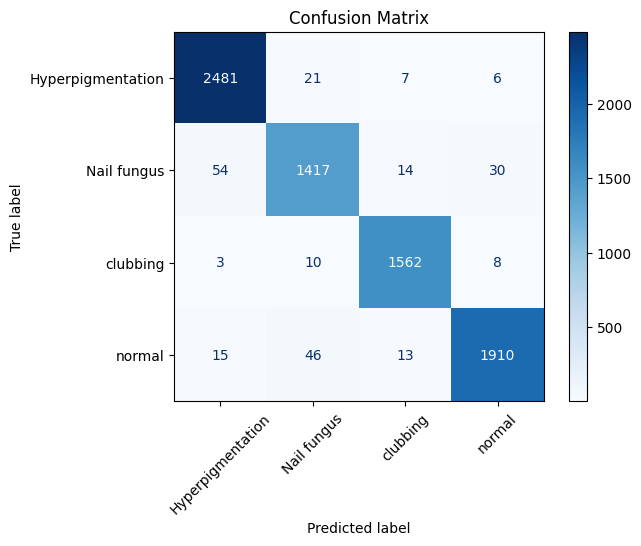


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation       0.97      0.99      0.98      2515
      Nail fungus       0.95      0.94      0.94      1515
         clubbing       0.98      0.99      0.98      1583
           normal       0.98      0.96      0.97      1984

         accuracy                           0.97      7597
        macro avg       0.97      0.97      0.97      7597
     weighted avg       0.97      0.97      0.97      7597


Final Test/Validation Accuracy: 0.9701
Final Test/Validation Loss:     0.1074


In [41]:
test_it.reset()
Y_pred = model.predict(test_it, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_it.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure()
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

test_loss, test_acc = model.evaluate(test_it, verbose=0)
print(f"\nFinal Test/Validation Accuracy: {test_acc:.4f}")
print(f"Final Test/Validation Loss:     {test_loss:.4f}")


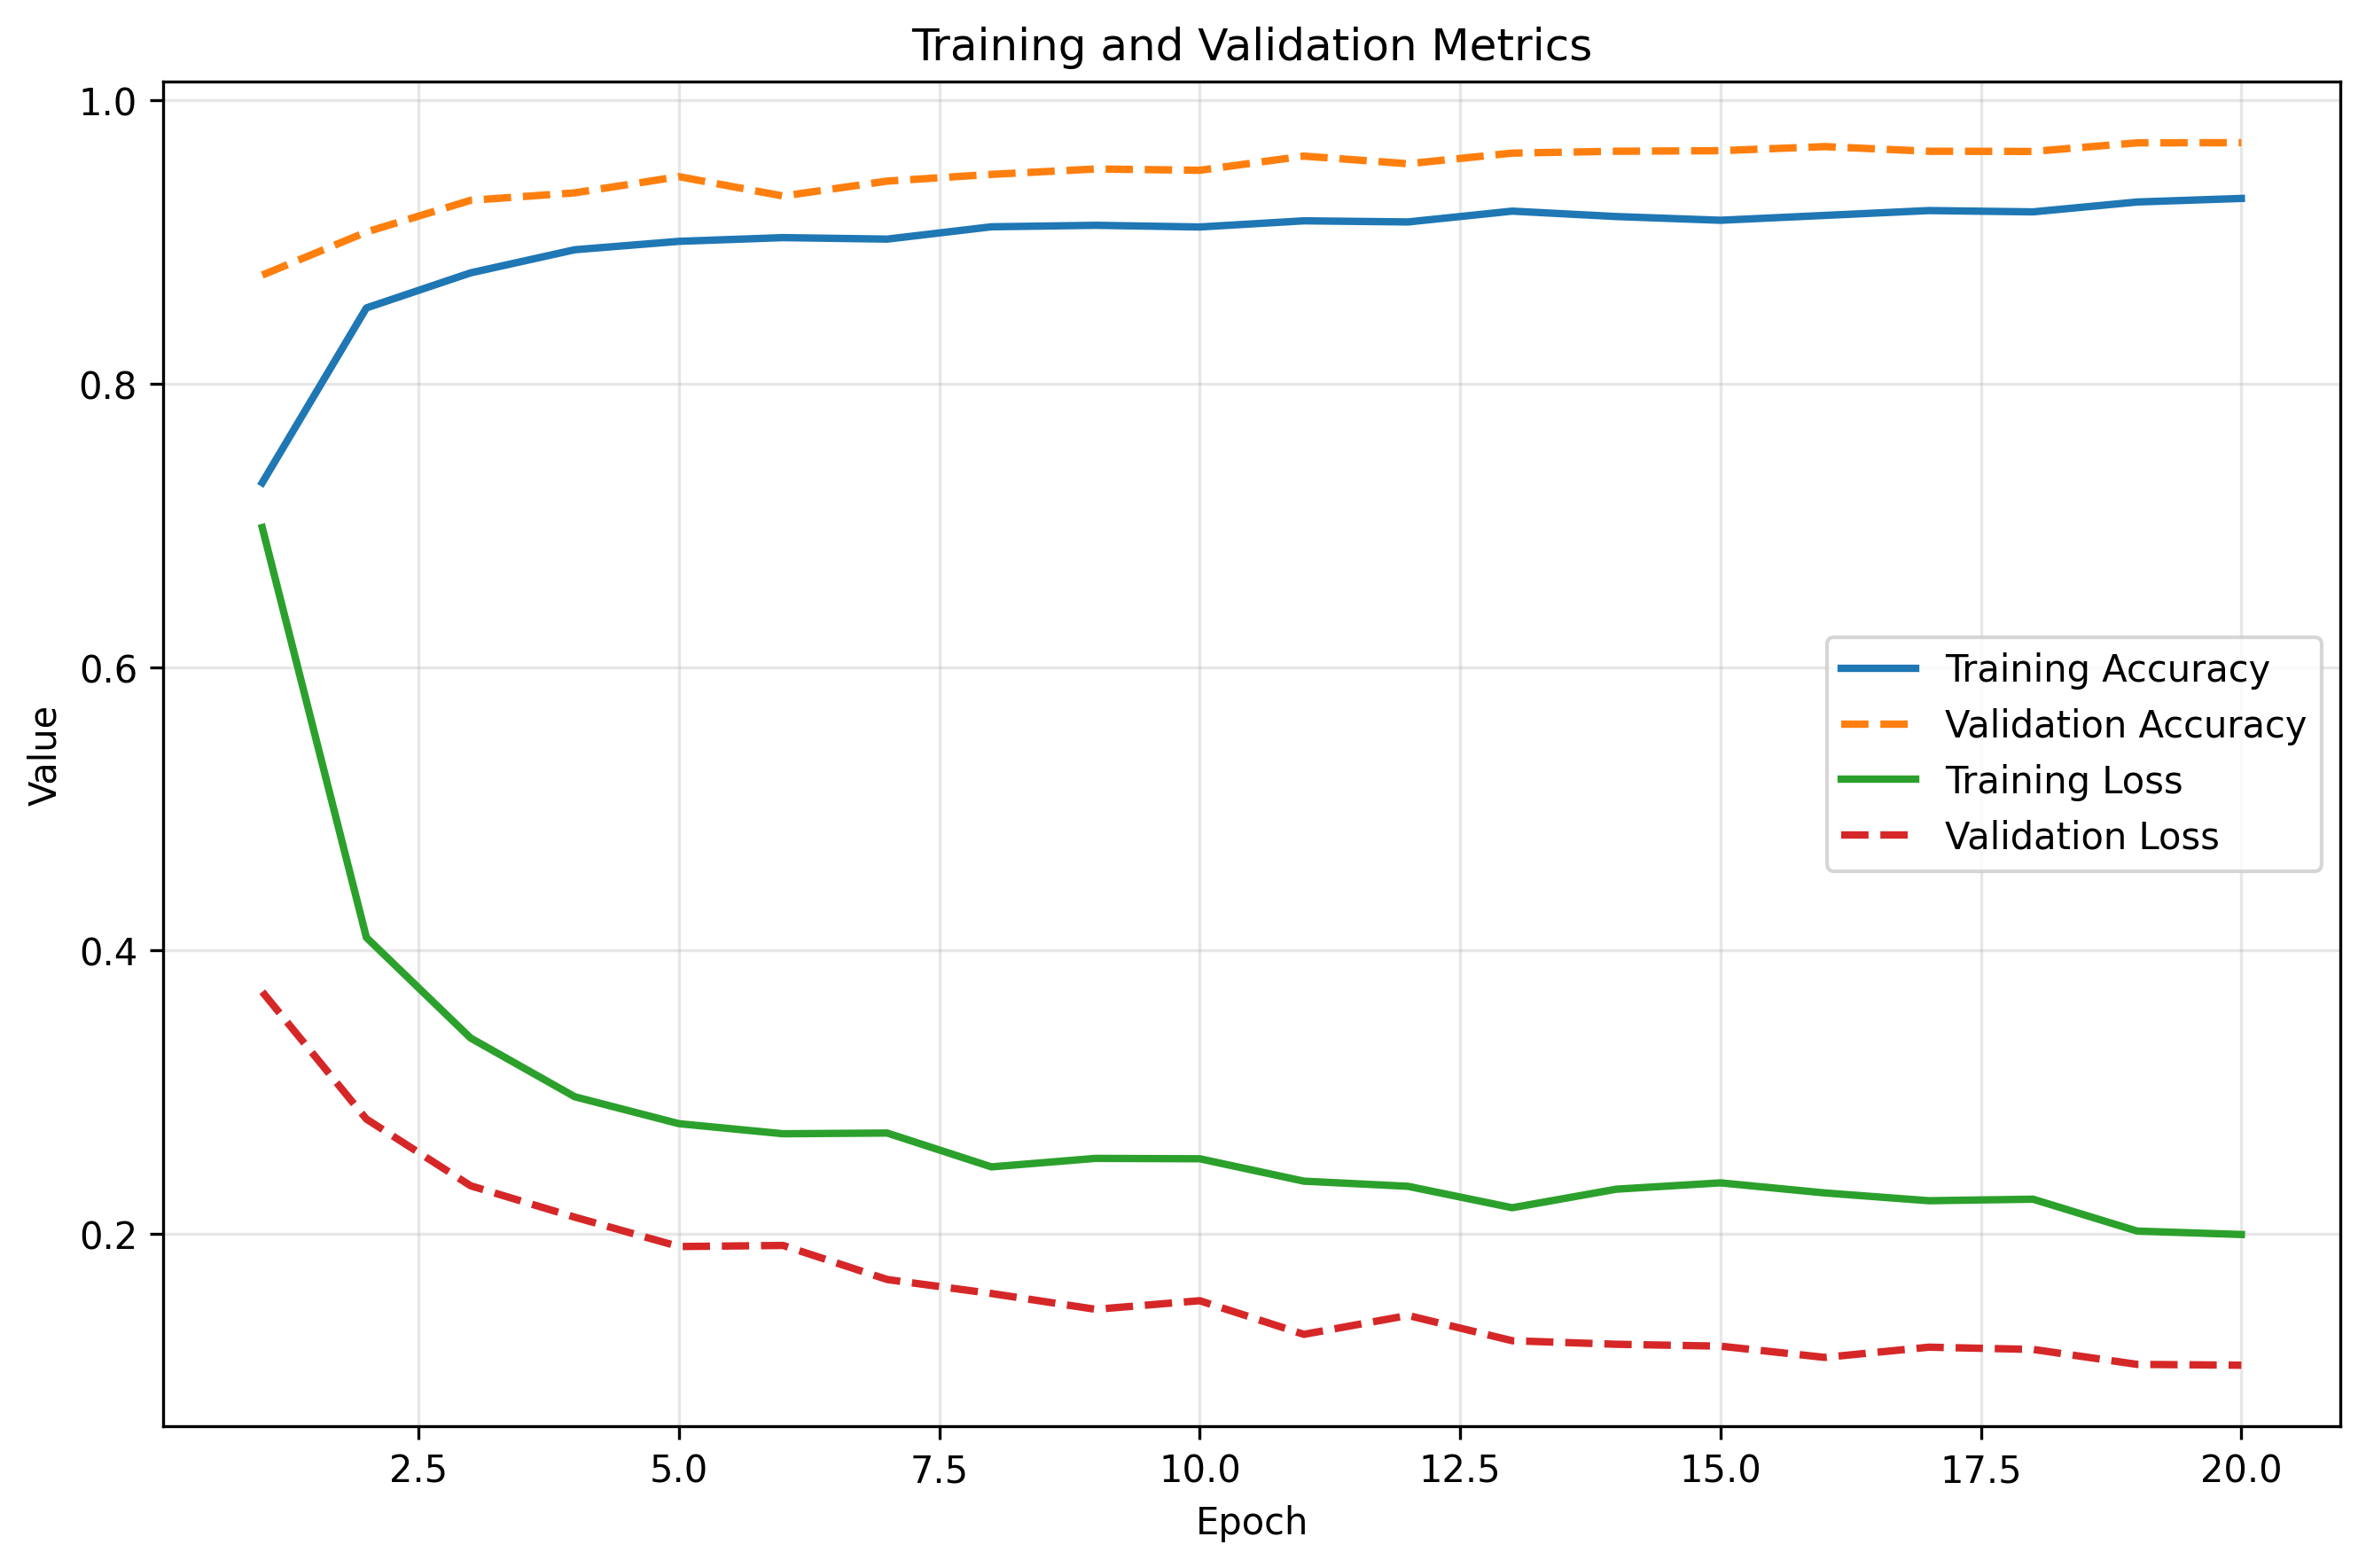

In [48]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(9, 6), dpi=300)

plt.plot(epochs, history.history["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy", linewidth=2, linestyle="--")

plt.plot(epochs, history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(epochs, history.history["val_loss"], label="Validation Loss", linewidth=2, linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_validation_all_metrics.png", dpi=300, bbox_inches="tight")
plt.savefig("training_validation_all_metrics.pdf", bbox_inches="tight")
plt.show()


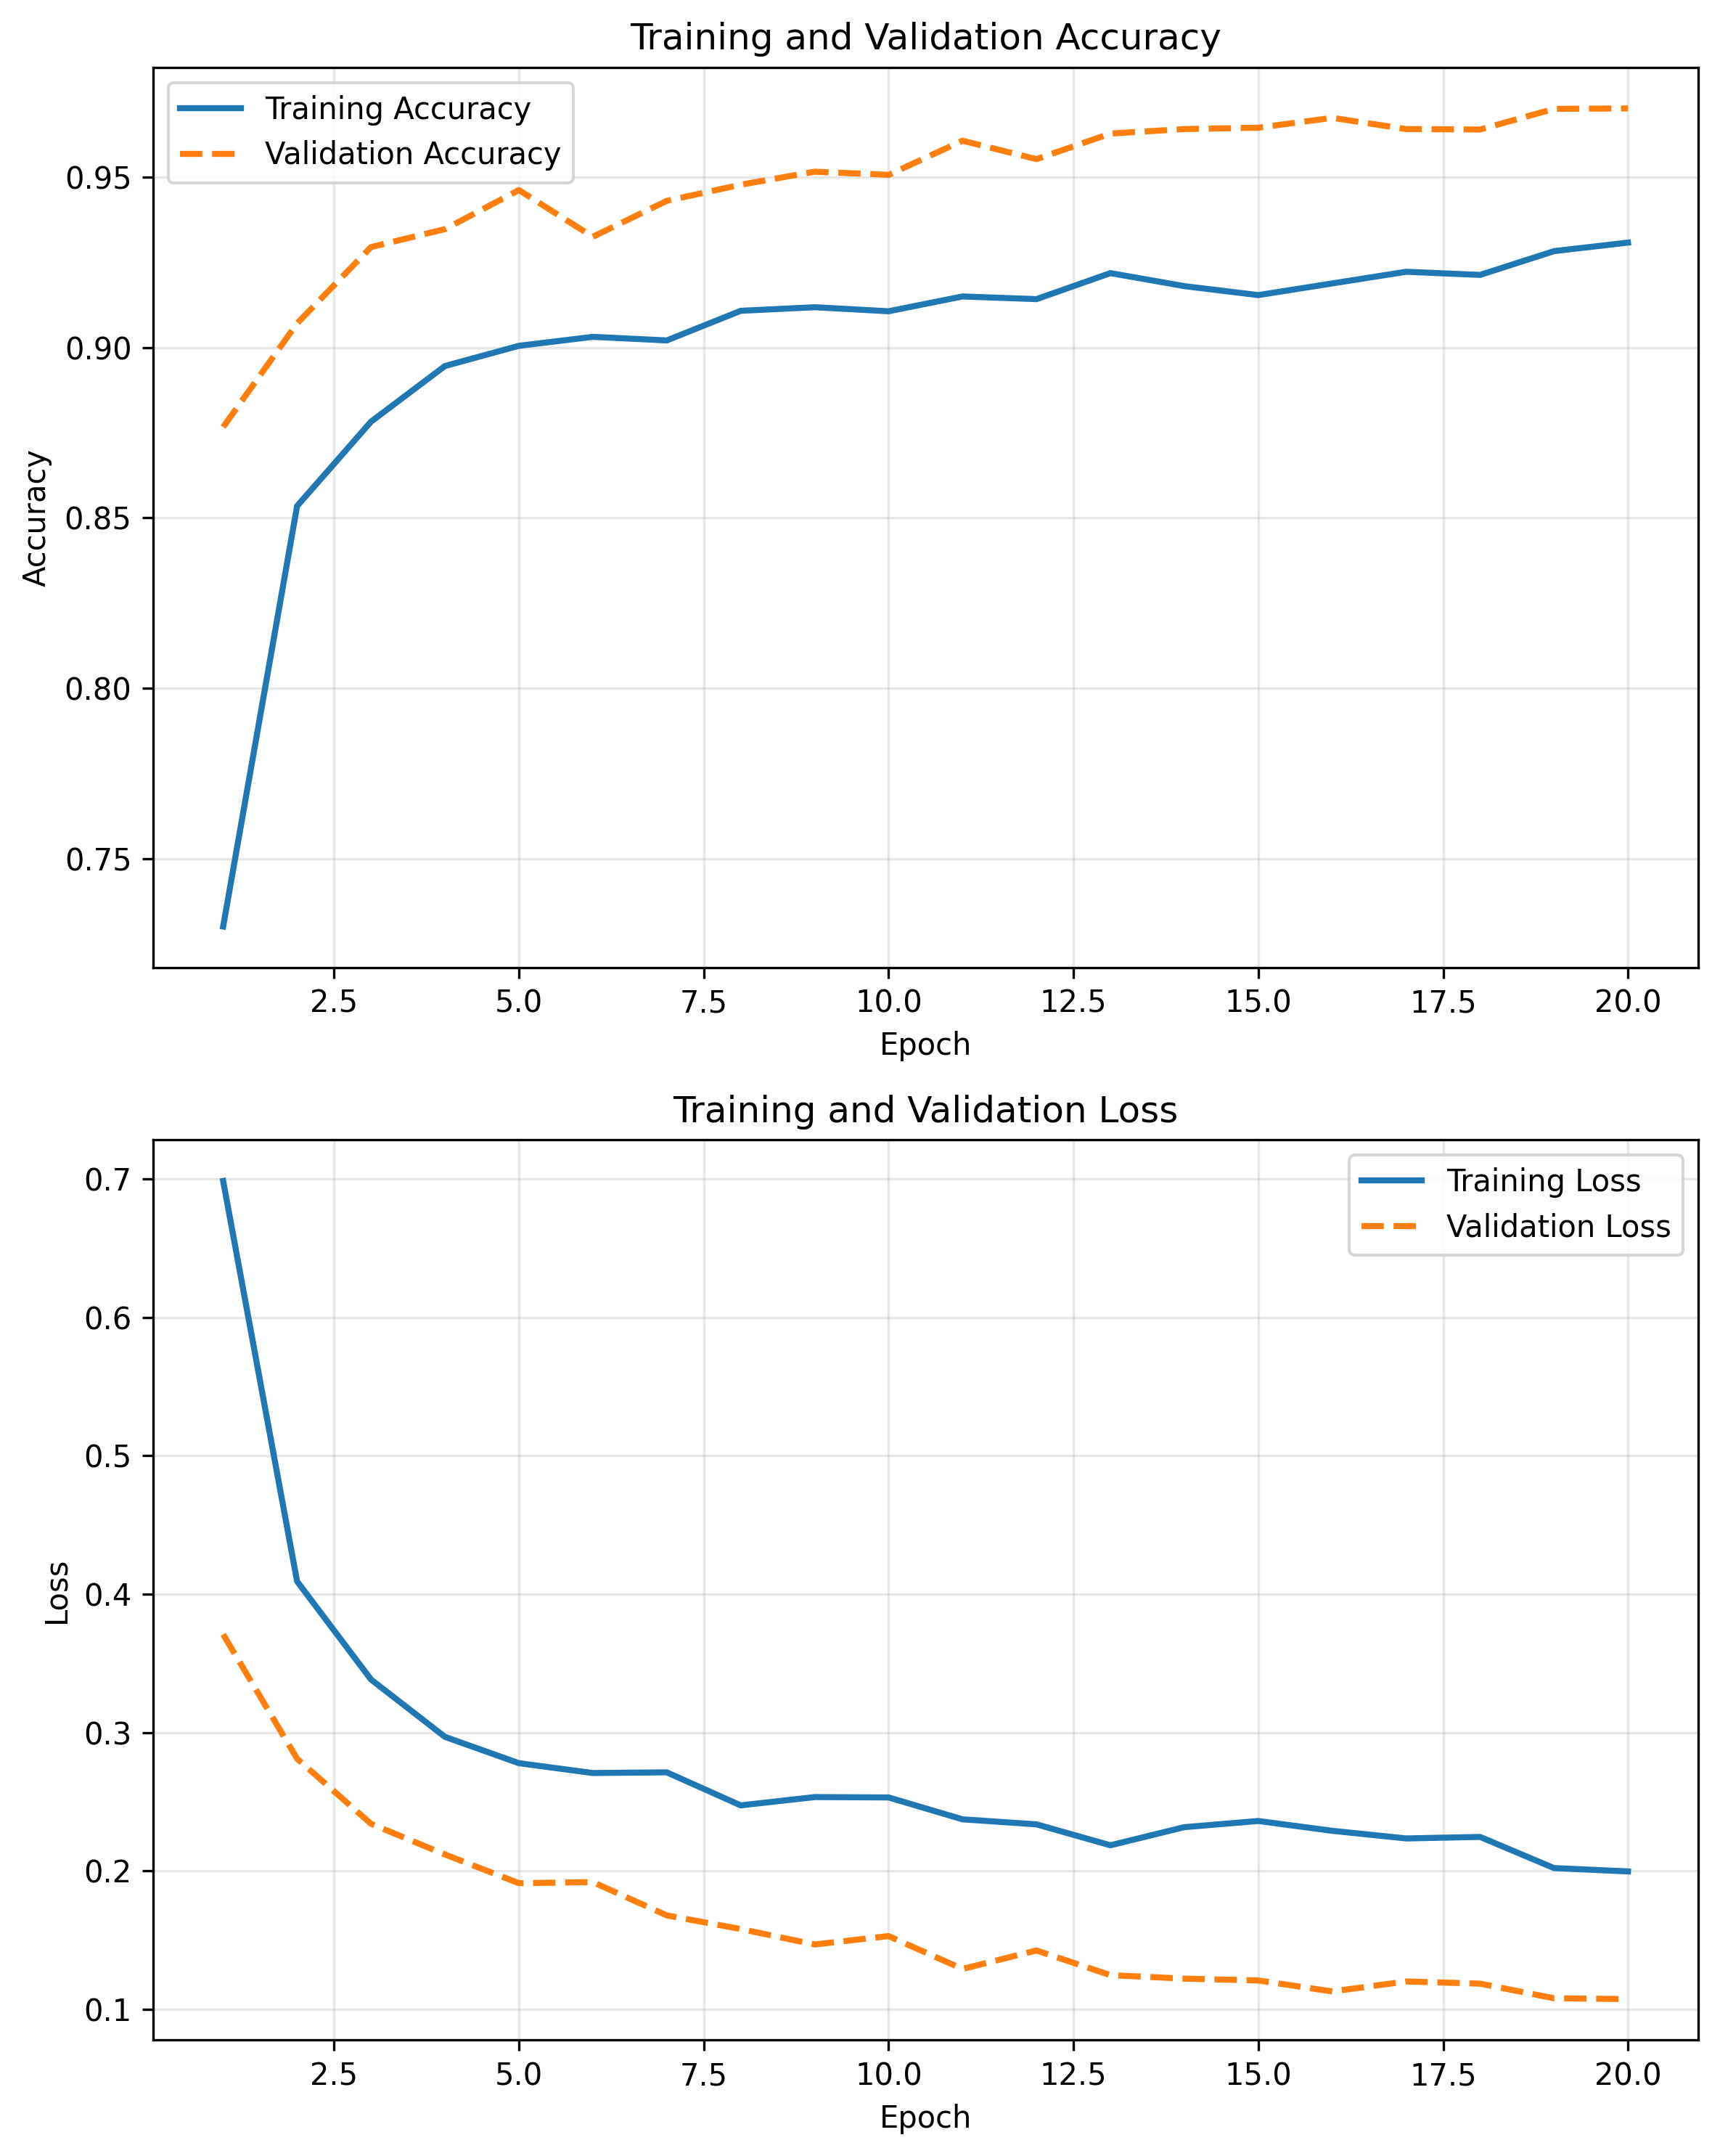

In [52]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(8, 10), dpi=300)

# -------- Accuracy --------
plt.subplot(2, 1, 1)
plt.plot(epochs, history.history["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# -------- Loss --------
plt.subplot(2, 1, 2)
plt.plot(epochs, history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(epochs, history.history["val_loss"], label="Validation Loss", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_validation_metrics.png", dpi=300, bbox_inches="tight")
plt.savefig("training_validation_metrics.pdf", bbox_inches="tight")
plt.show()
